In [2]:
%matplotlib inline
import sys
import cv2
import re
import csv

sys.path.append('..')

import math as m
import numpy as np
from PIL import Image

import scipy.optimize as opt

import matplotlib
import matplotlib.pyplot as plt

from core import Core

from global_var import COLORS


In [3]:
matplotlib.rc('font', family='serif') 
matplotlib.rc('font', serif='Palatino Linotype') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 20})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


<ipython-input-137-ca1ea295bee6>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165


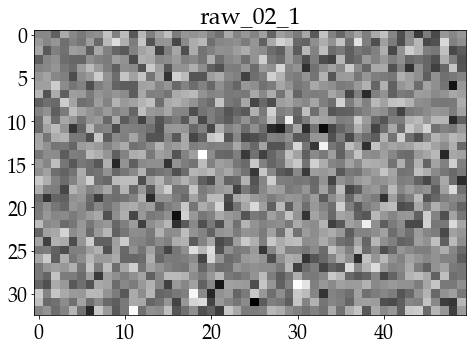

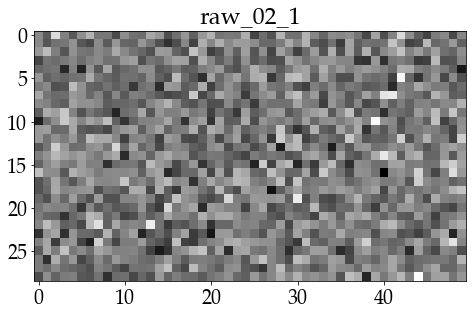

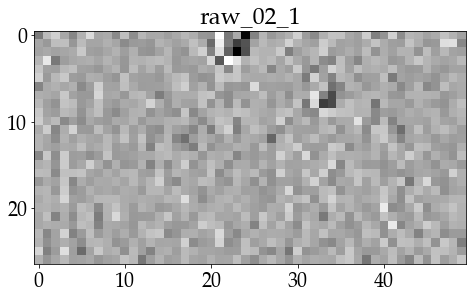

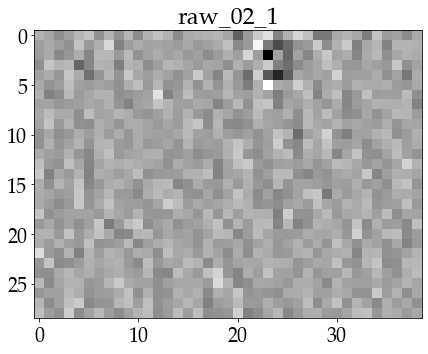

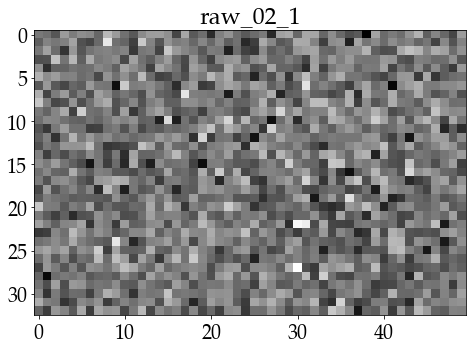

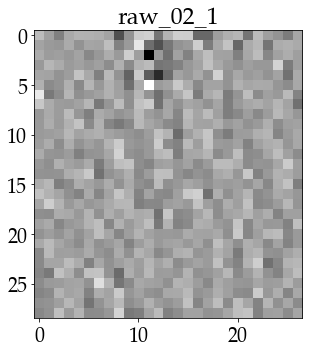

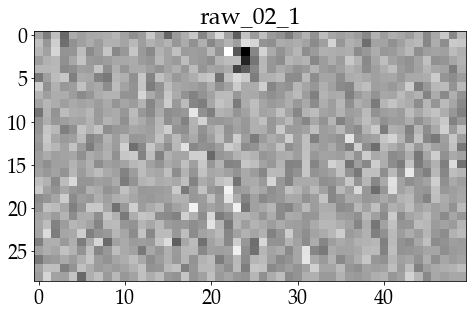

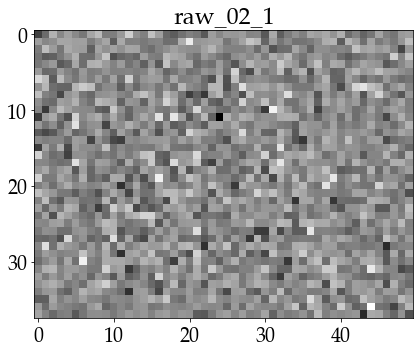

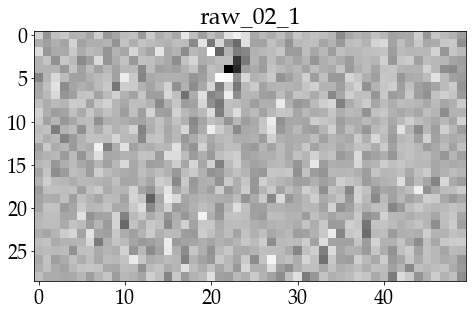

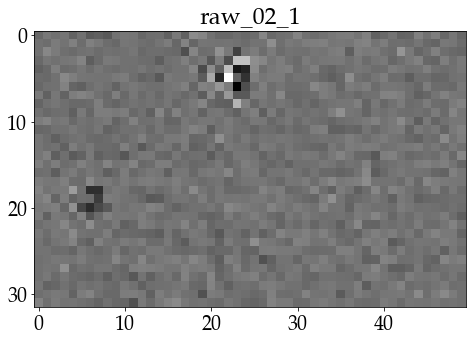

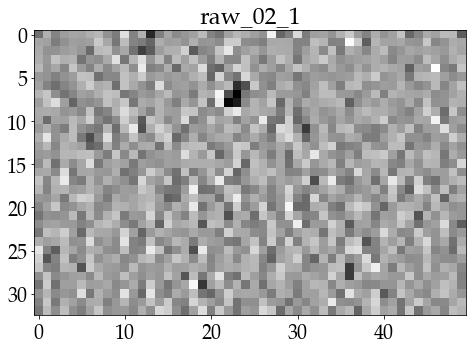

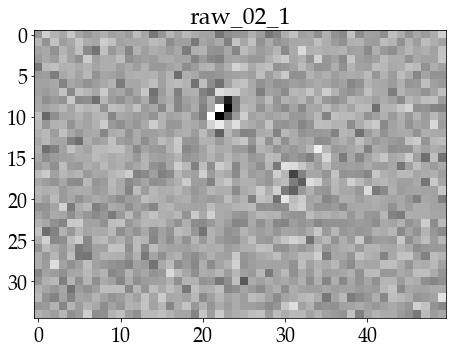

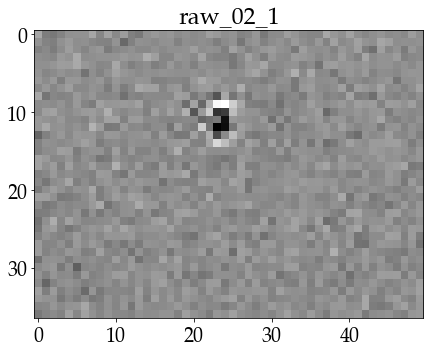

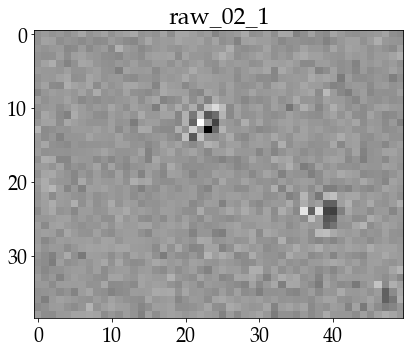

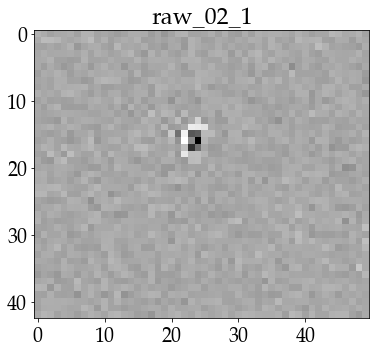

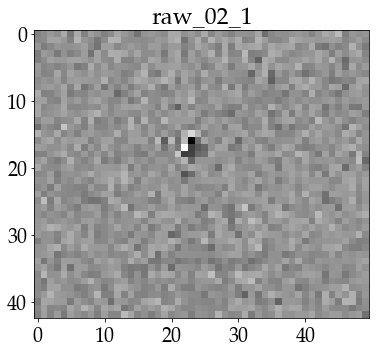

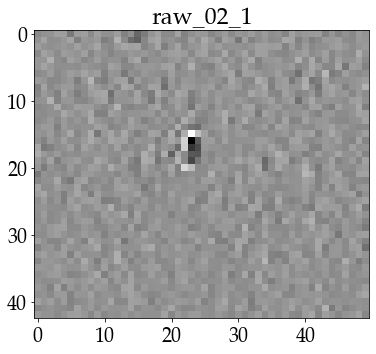

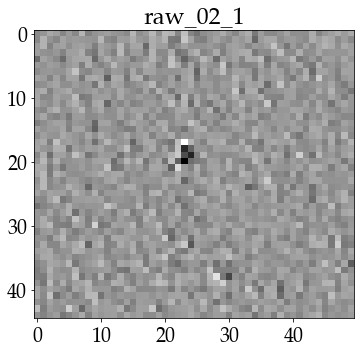

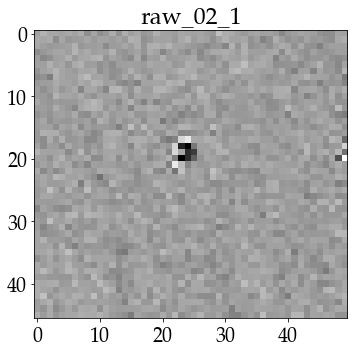

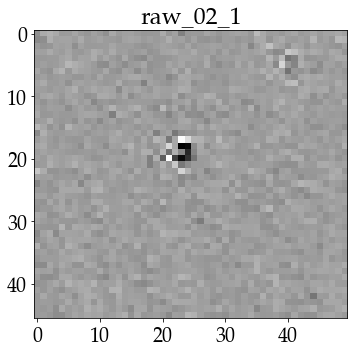

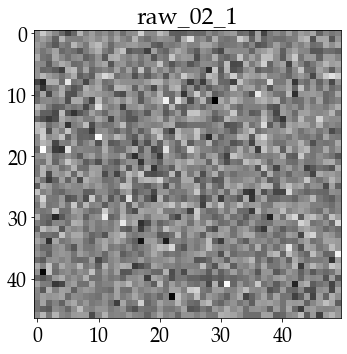

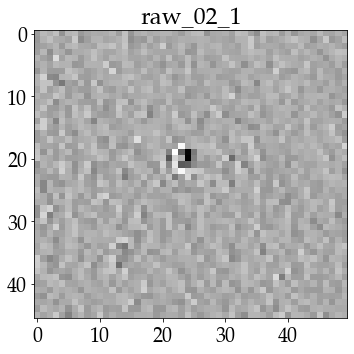

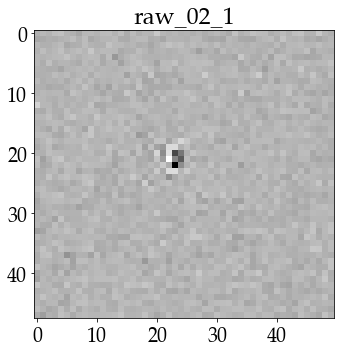

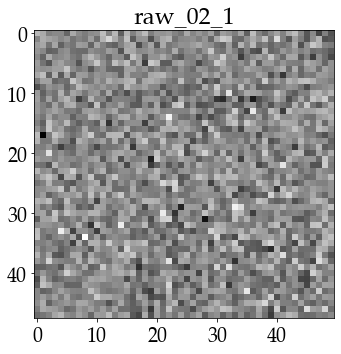

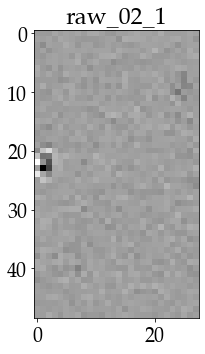

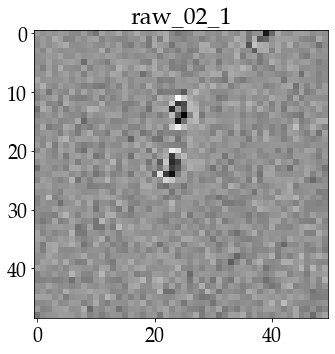

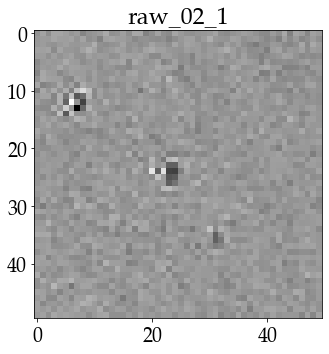

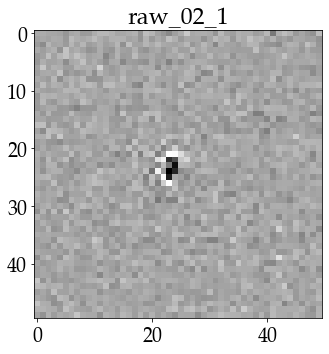

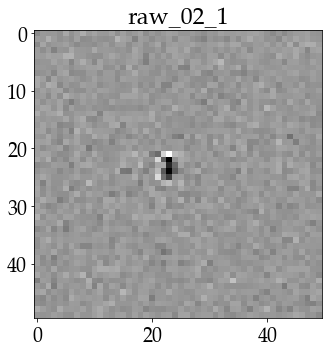

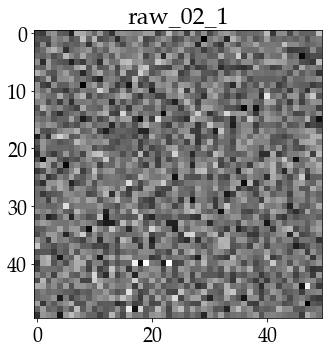

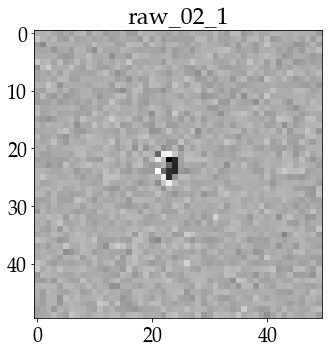

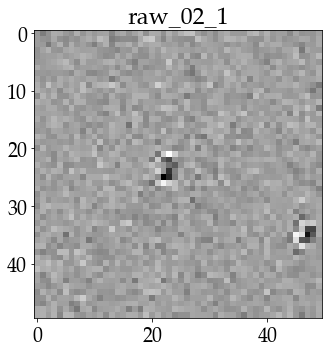

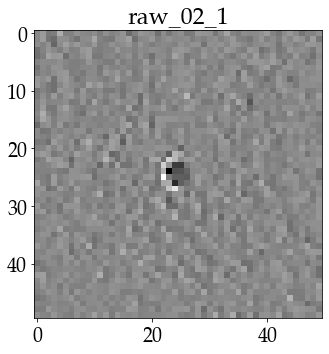

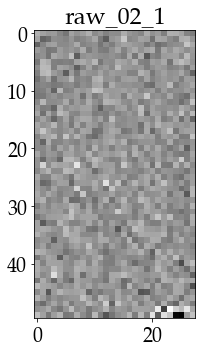

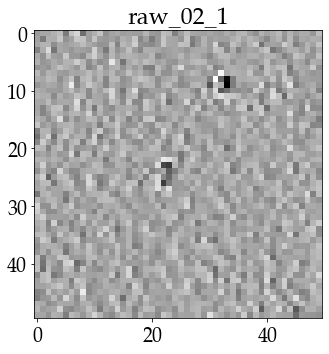

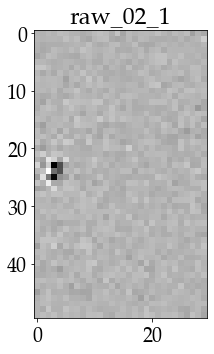

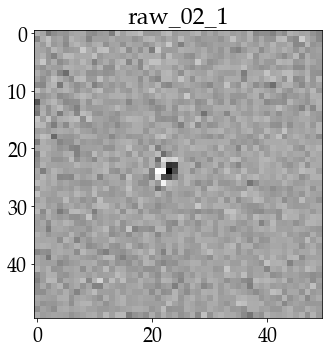

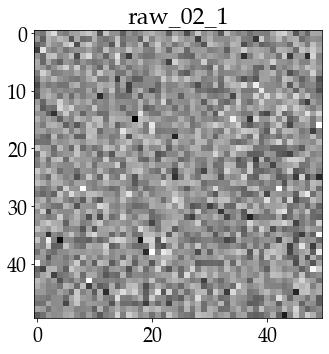

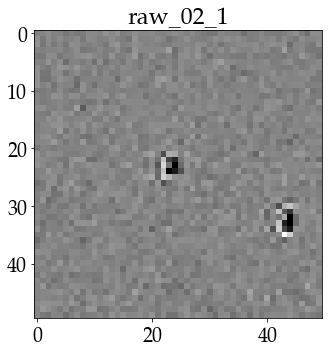

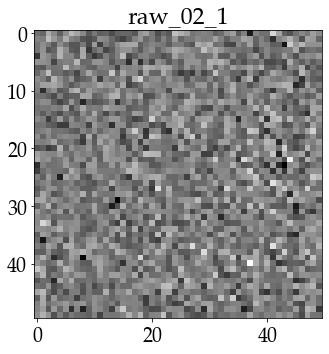

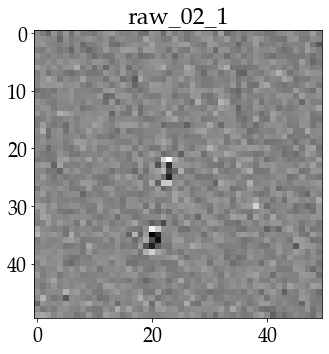

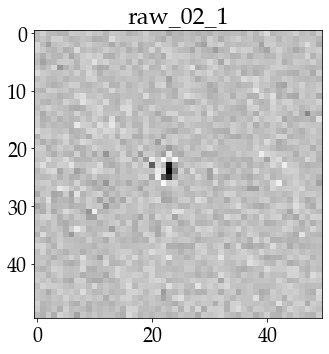

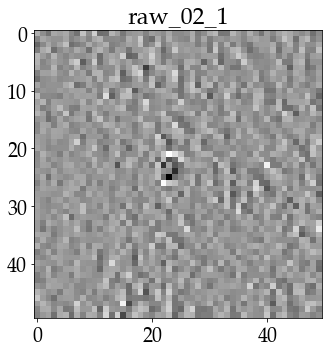

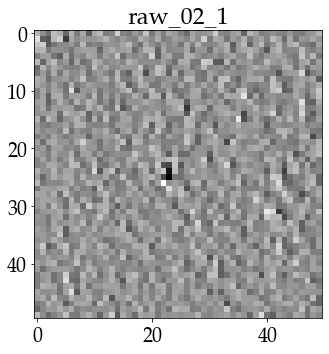

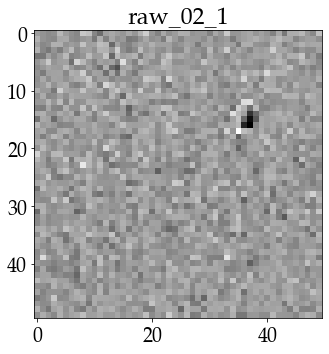

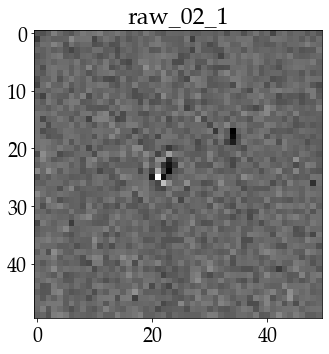

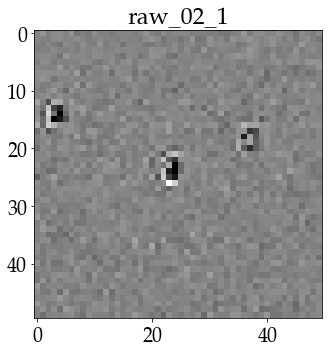

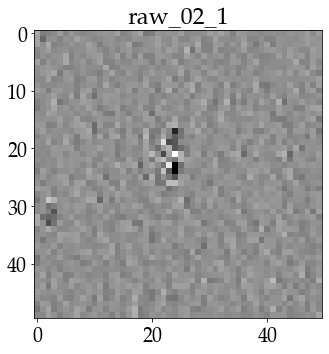

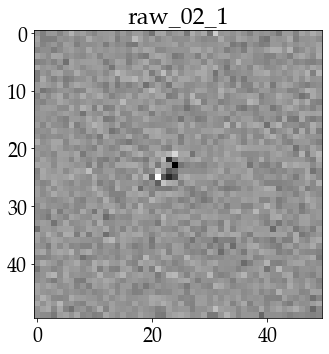

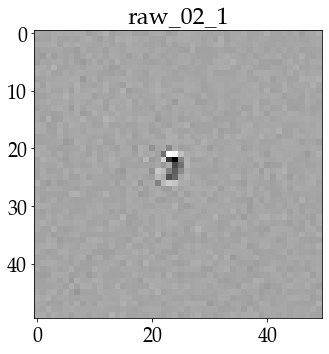

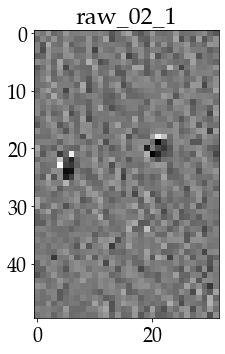

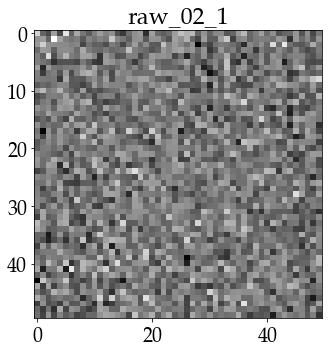

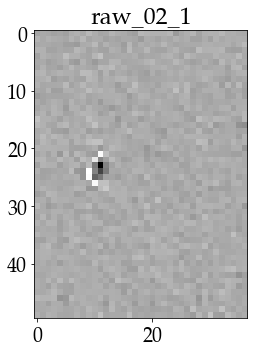

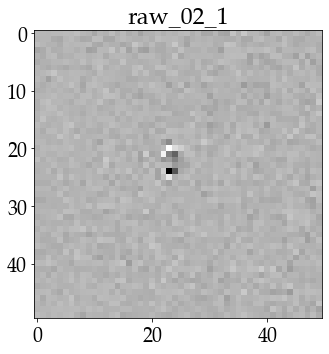

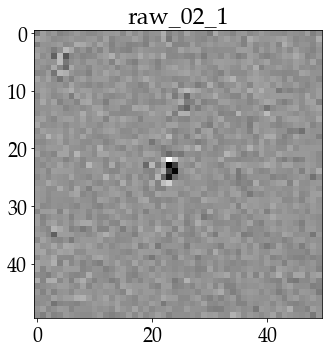

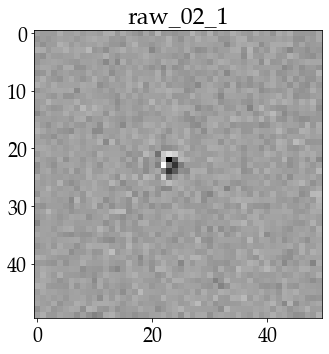

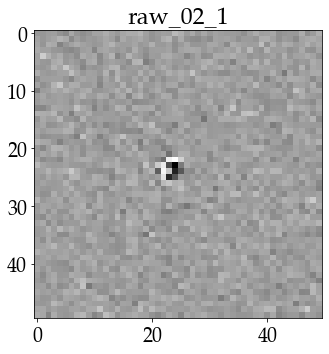

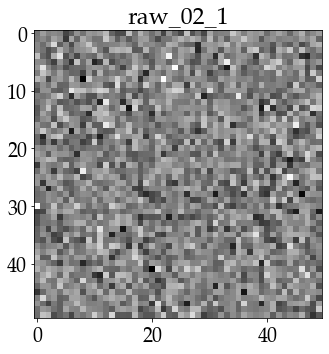

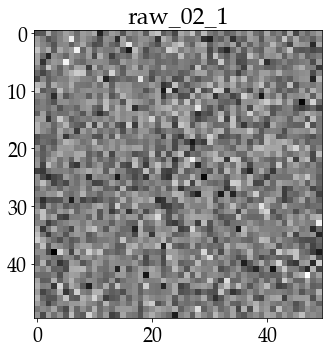

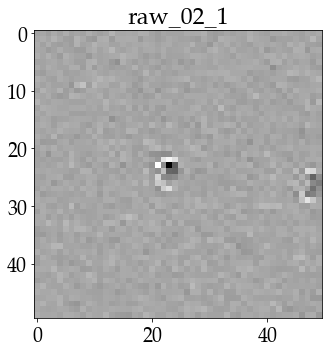

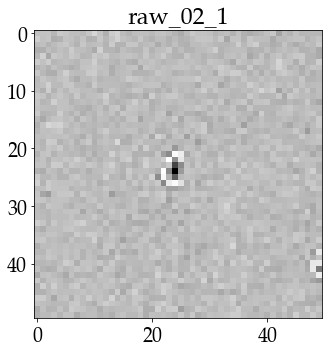

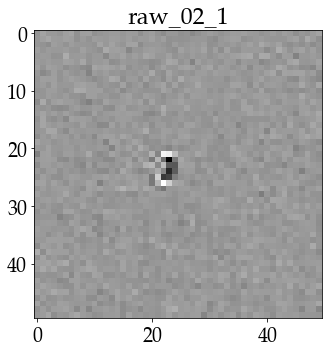

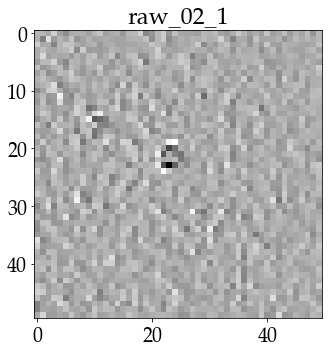

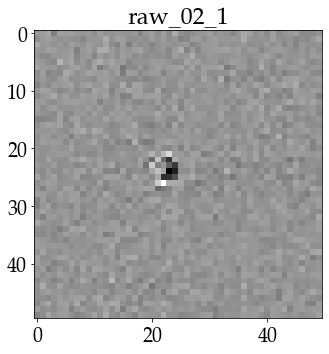

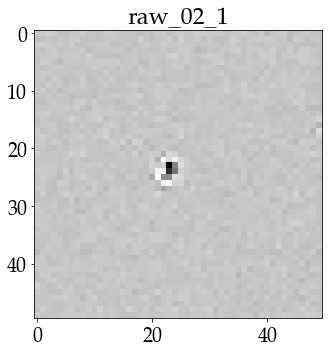

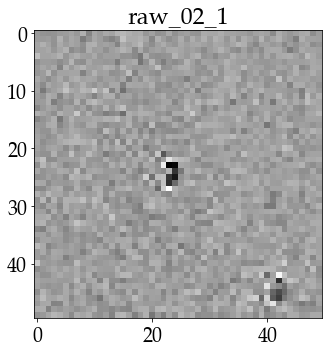

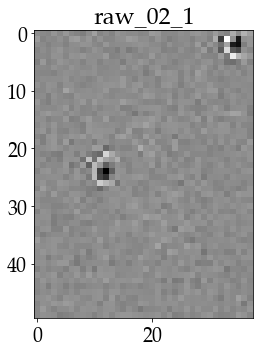

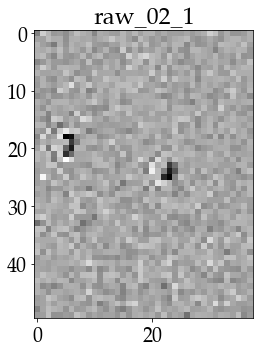

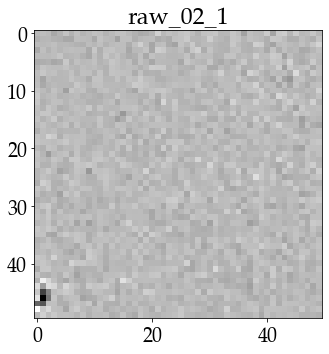

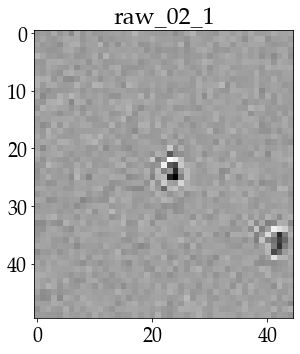

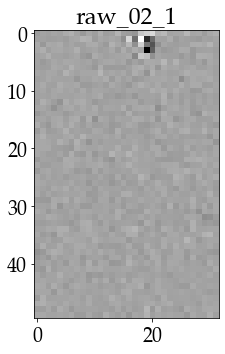

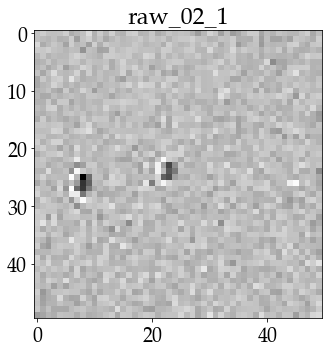

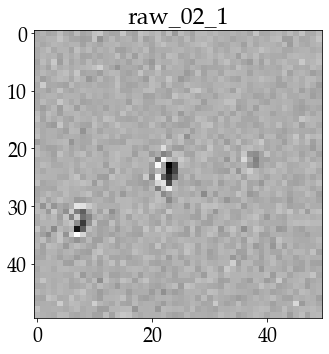

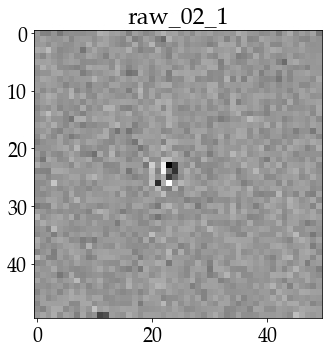

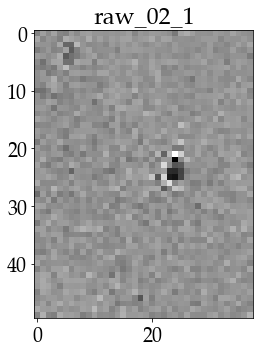

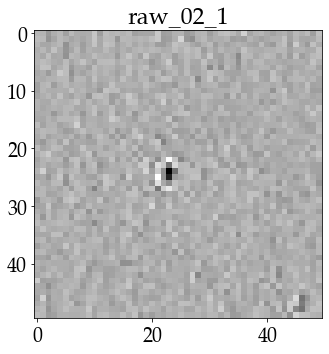

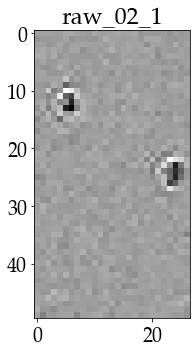

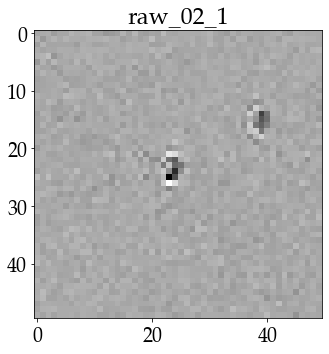

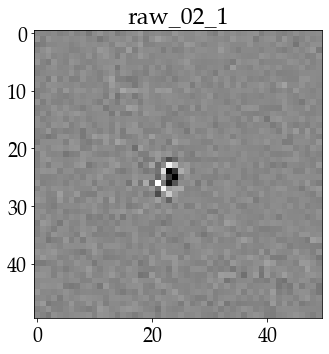

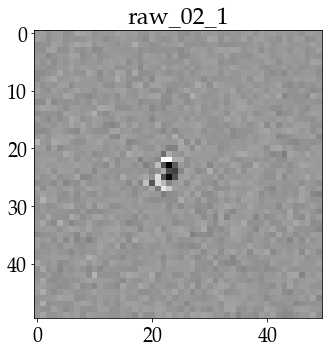

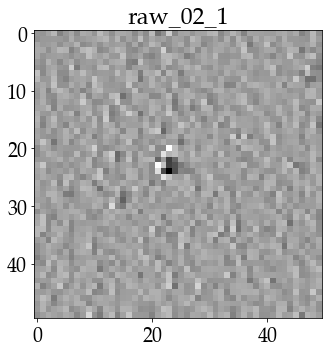

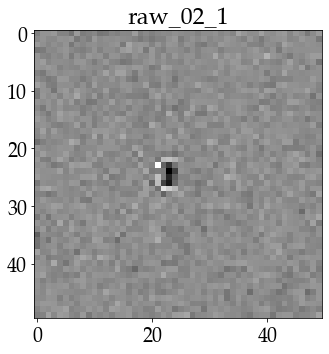

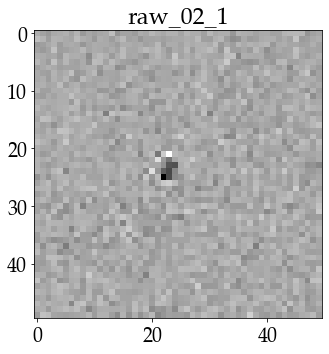

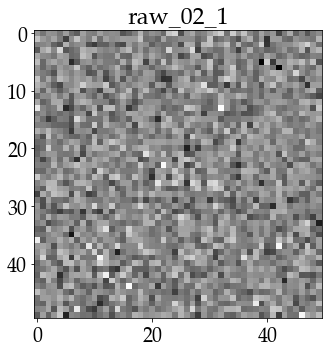

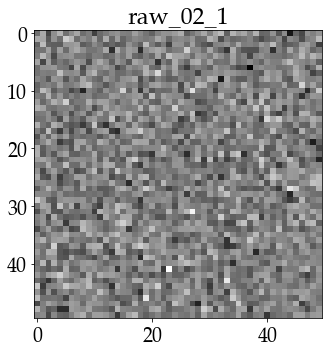

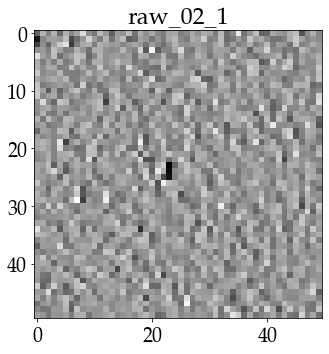

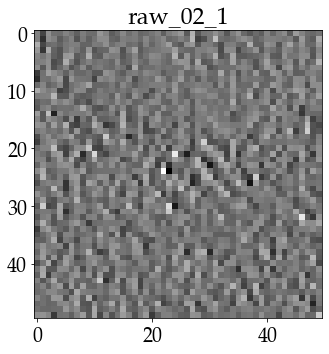

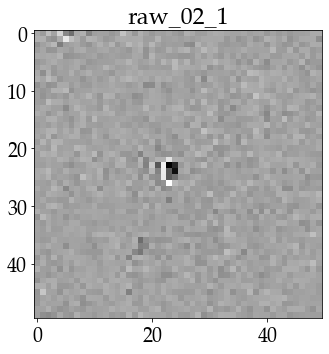

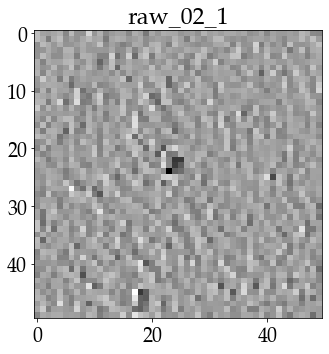

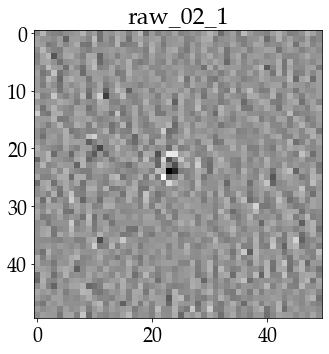

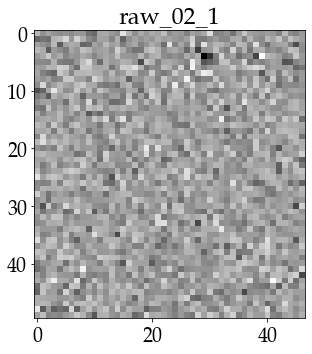

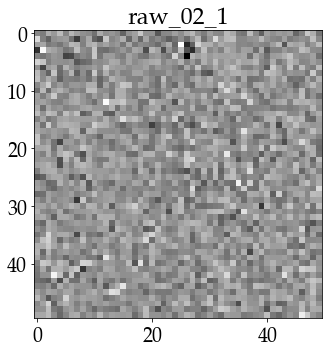

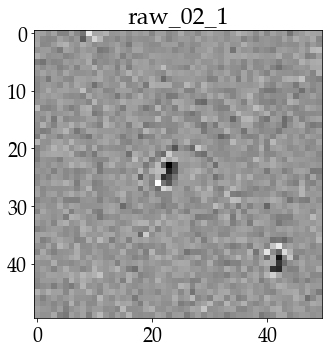

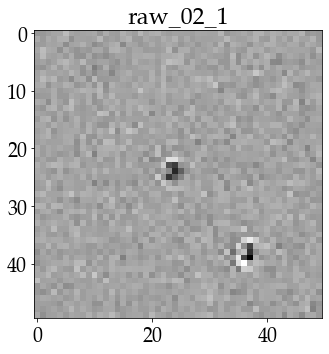

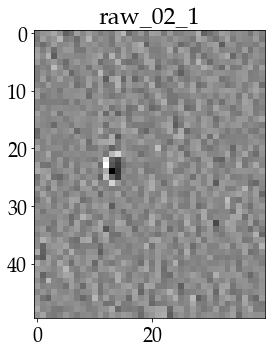

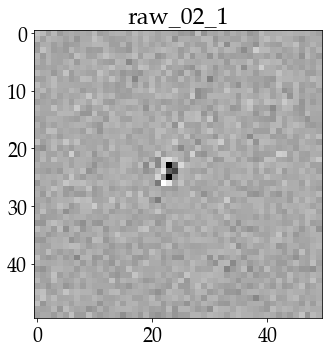

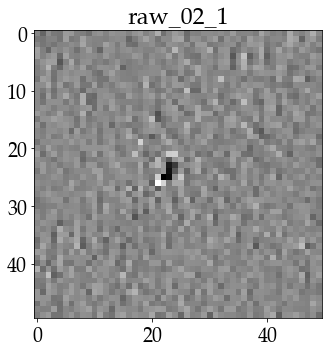

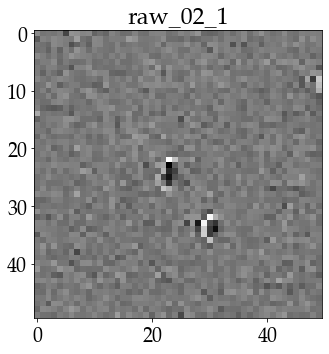

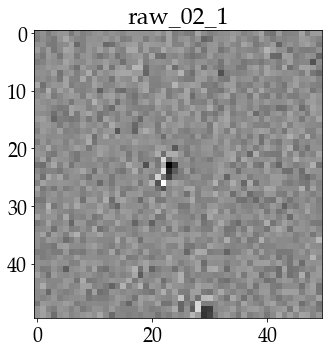

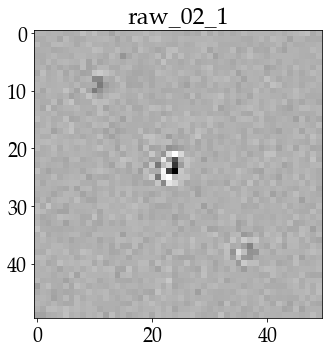

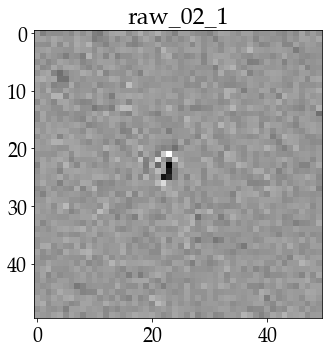

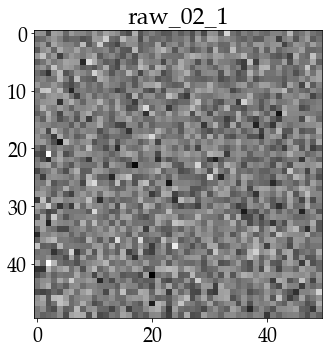

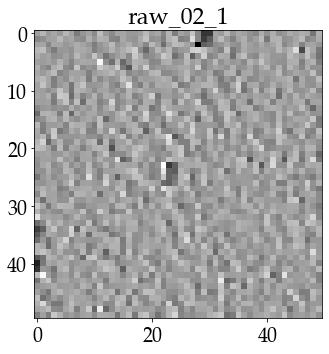

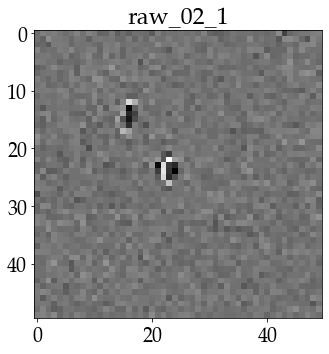

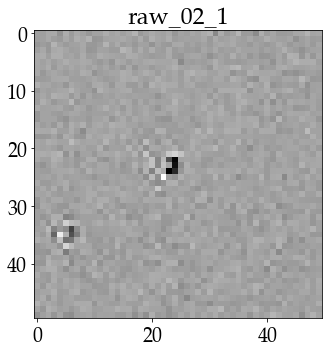

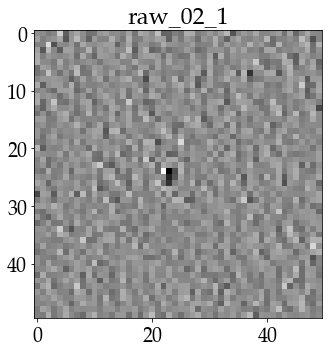

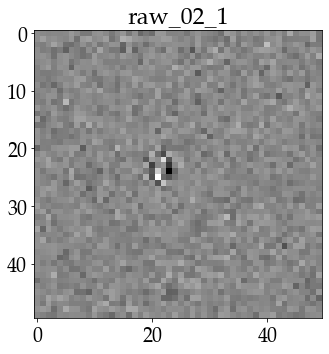

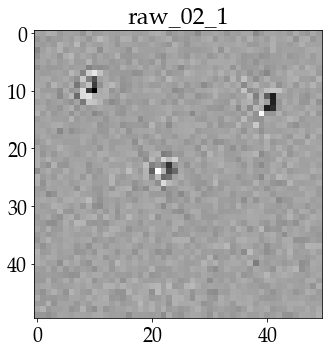

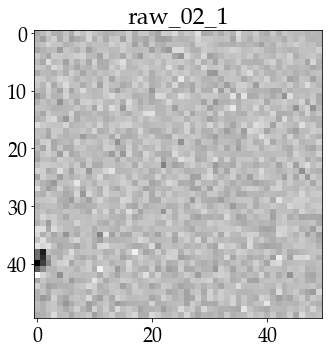

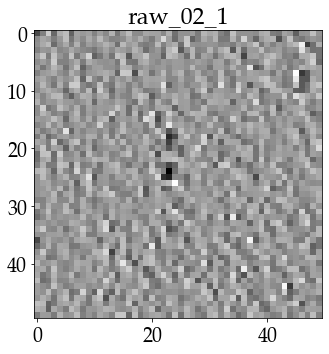

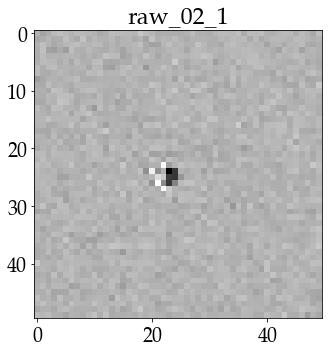

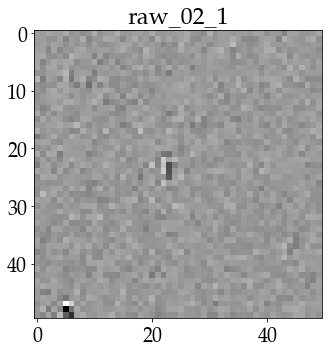

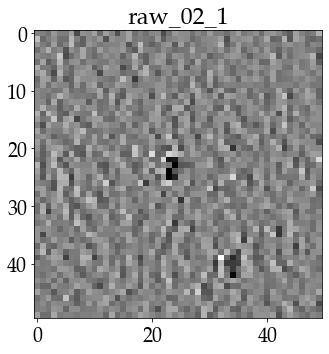

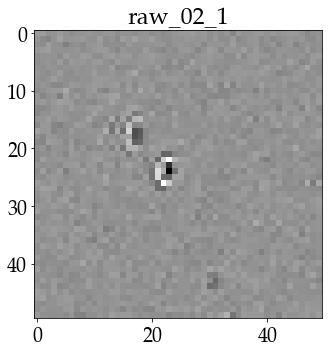

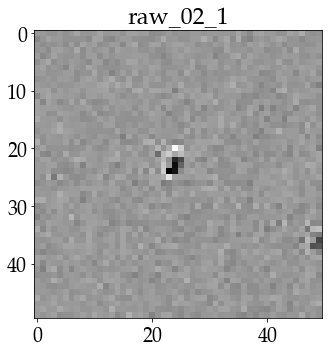

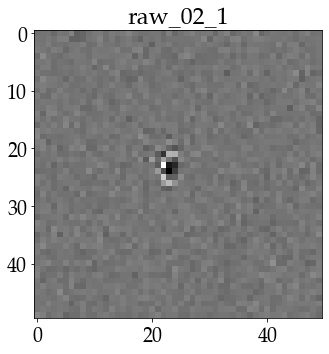

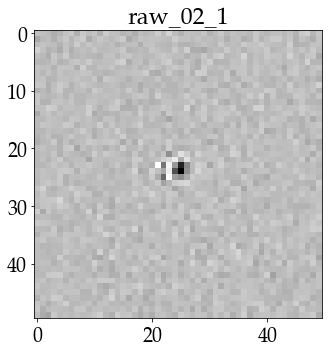

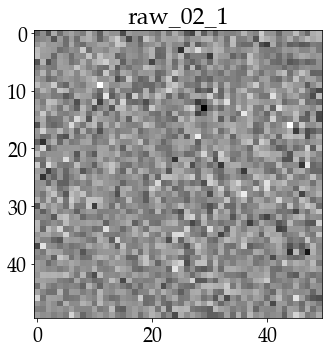

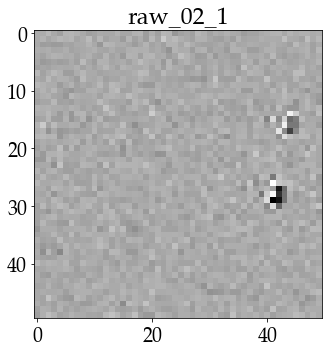

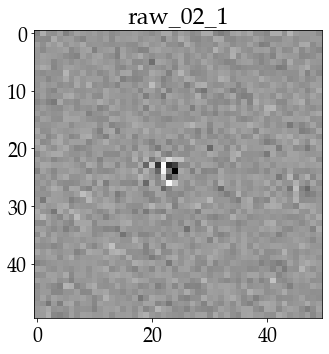

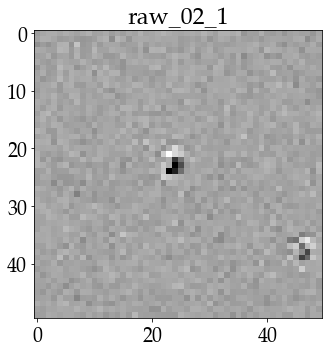

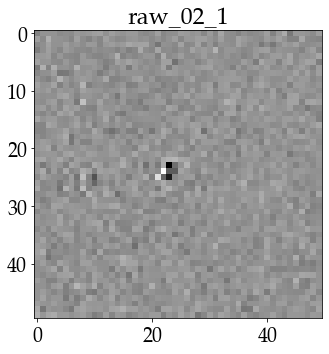

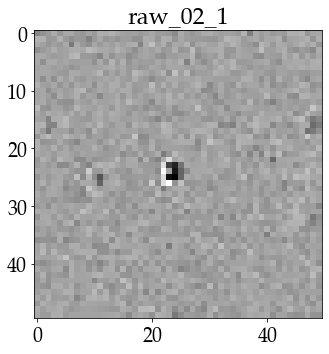

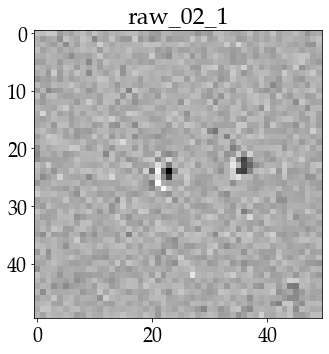

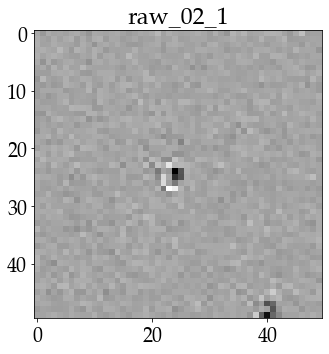

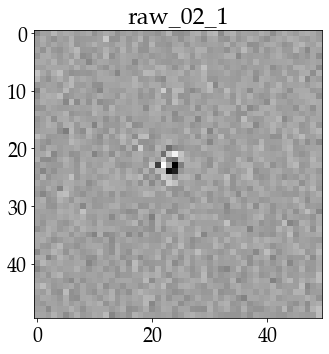

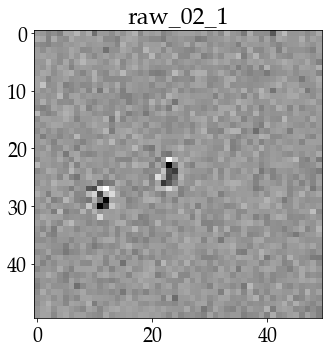

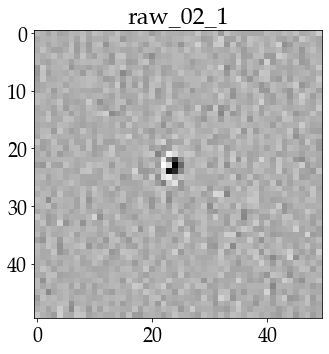

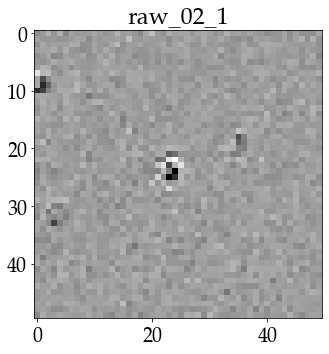

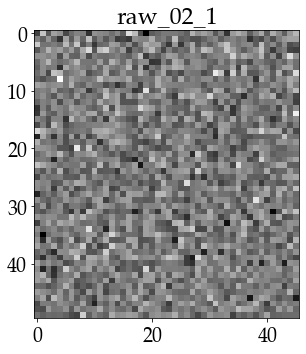

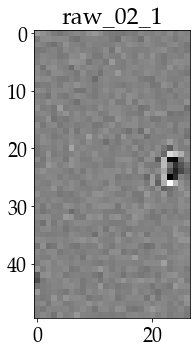

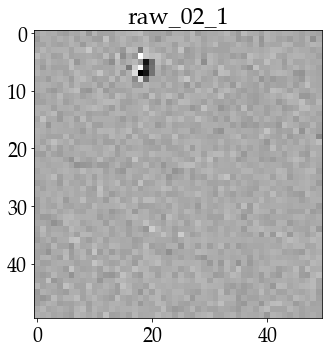

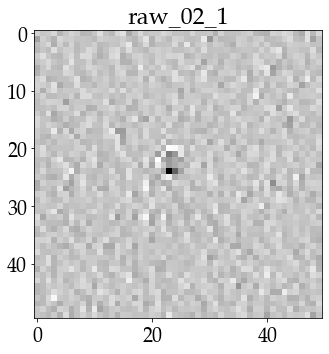

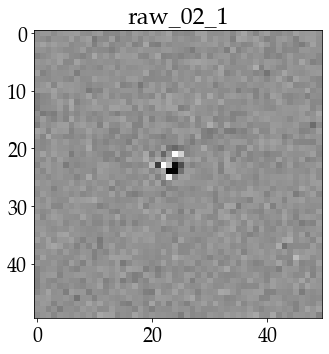

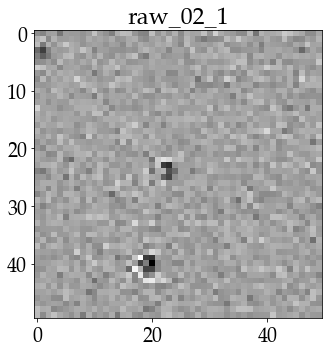

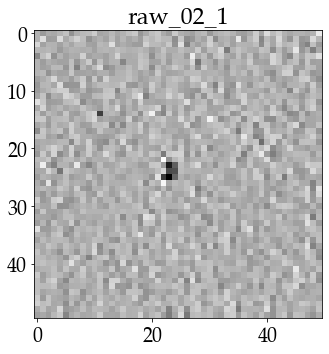

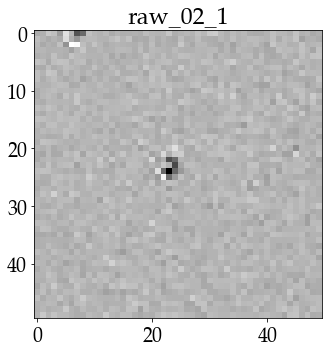

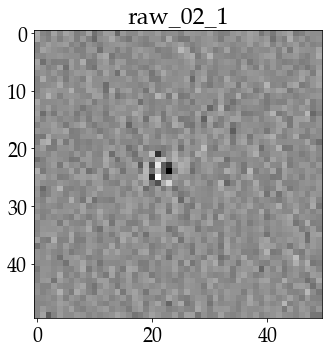

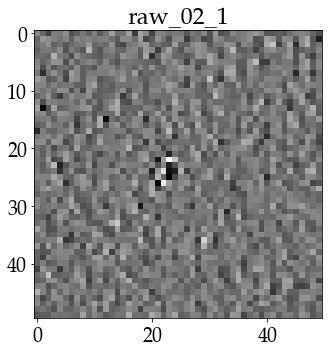

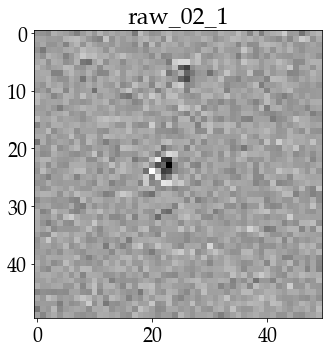

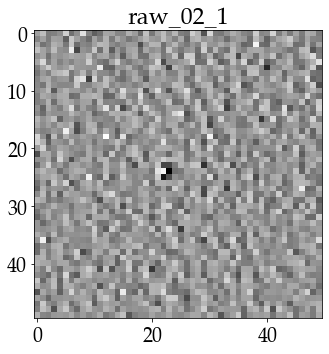

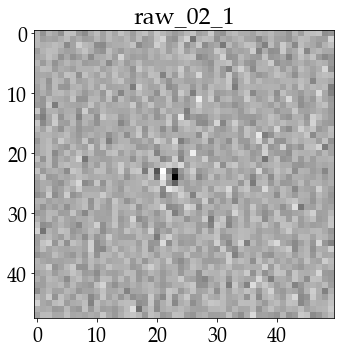

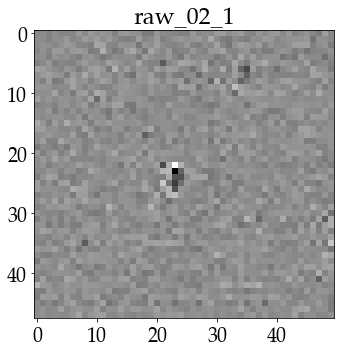

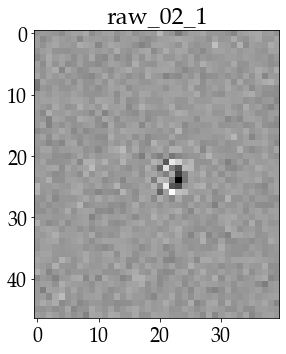

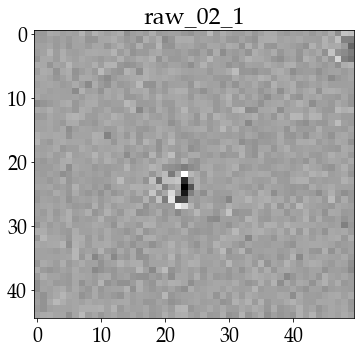

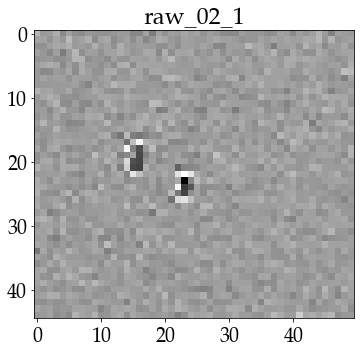

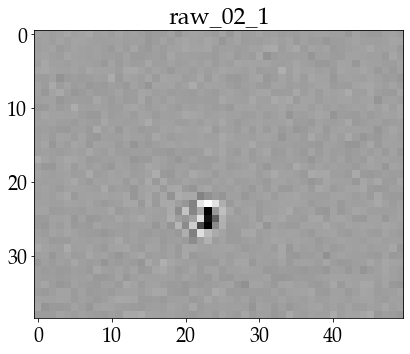

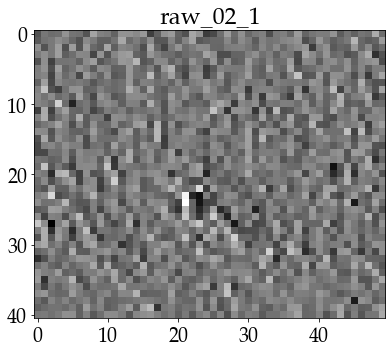

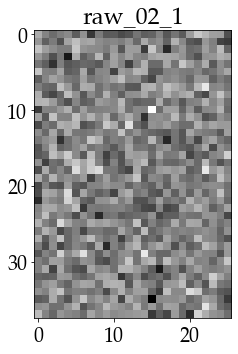

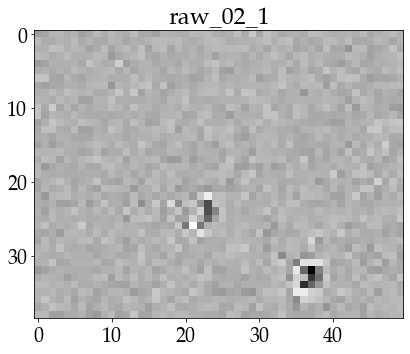

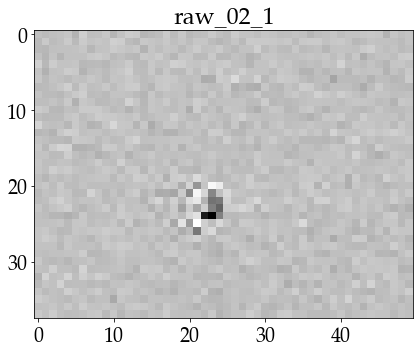

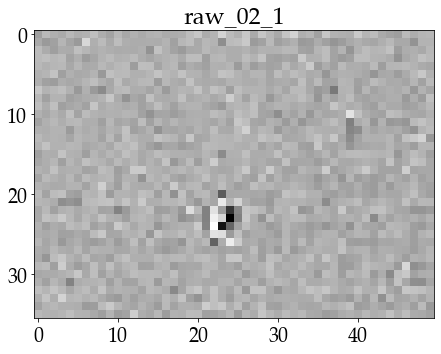

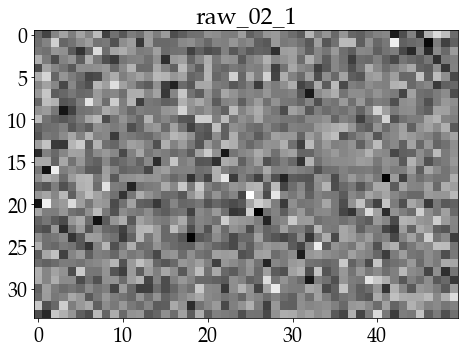

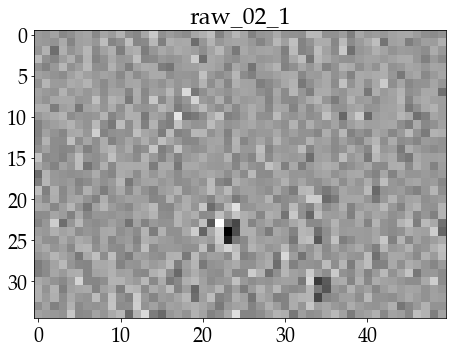

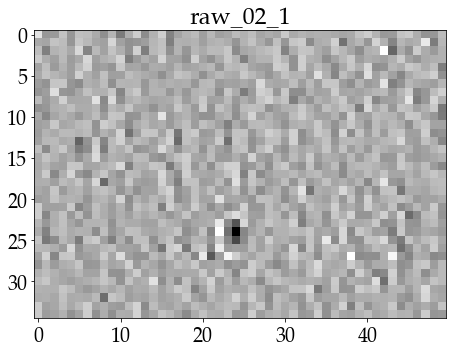

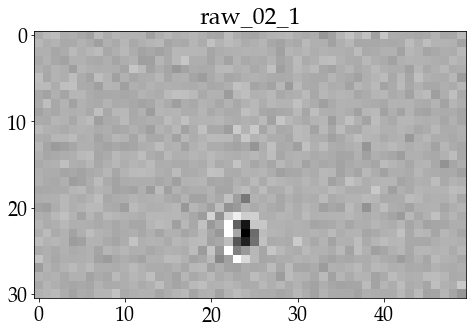

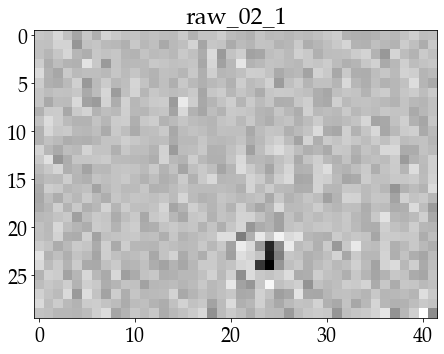

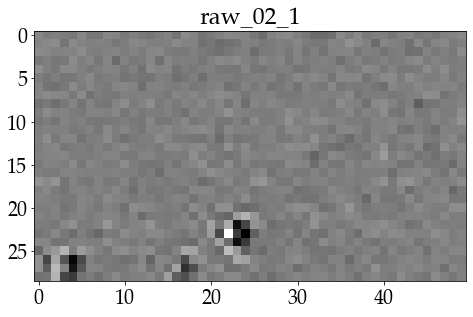

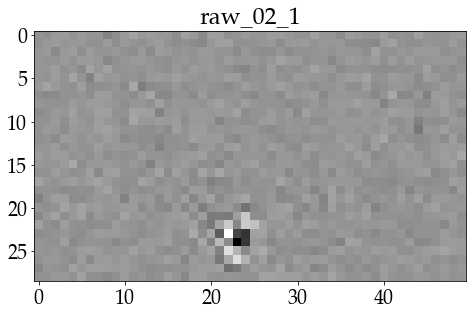

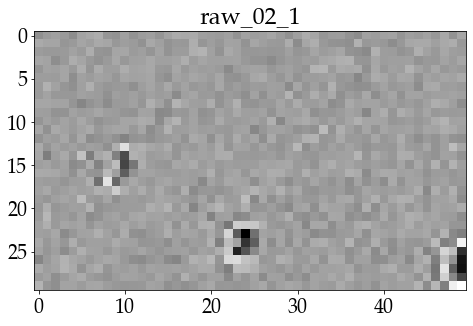

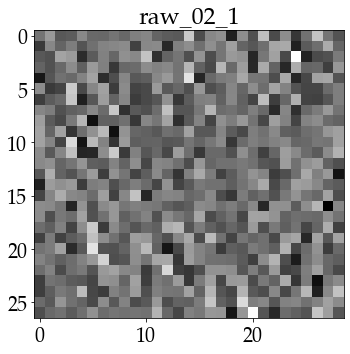

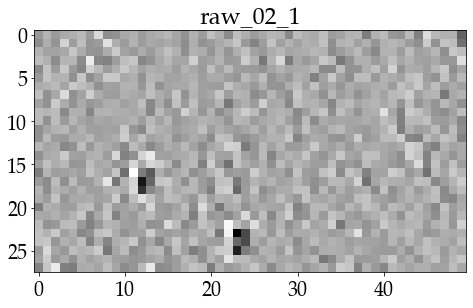

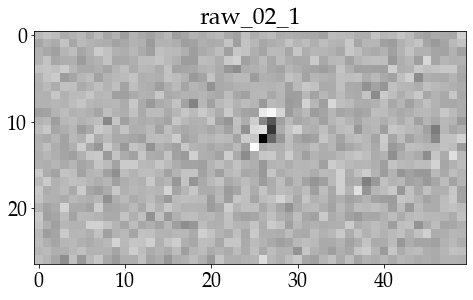

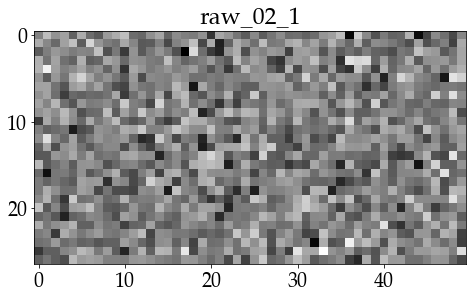

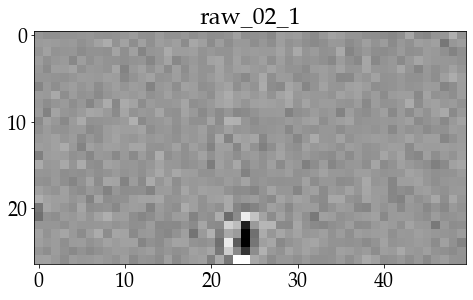

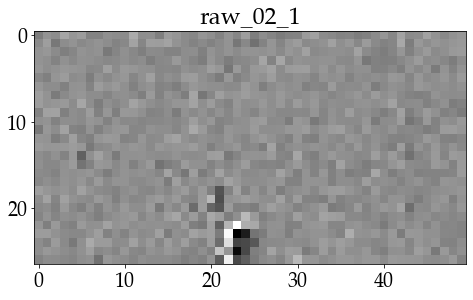

In [137]:
#save npy files as pngs

folder = r'C:\SPRUP_data_Jenda\2019_03_13_Jenda_microscopy\20_12_11_BC5\exports_np_surroundings'.replace('\\', '/')
file = 'raw_02_1'

for i in range(166):
    print(i)
    name = file + '_{:04.0f}'.format(i)
    file_name = folder + '/' + name
    npp = np.load(file_name + '.npy')
    
    fig = plt.figure()
    axes = fig.add_axes([0.1, 0.1, 1, 1])
    axes.set_title(file)
    axes.imshow(
        npp,
        cmap='gray'
    )
    fig.savefig(file_name +'.png', dpi=300, bbox_inches='tight')    

In [7]:
folder = r'C:\SPRUP_data_Jenda\2019_03_13_Jenda_microscopy\20_12_11_BC5\exports_np_surroundings'.replace('\\', '/')
file = 'raw_02_1'

file_name = folder + '/' + file + '_{:04.0f}'.format(79)

npp = np.load(file_name + '.npy')

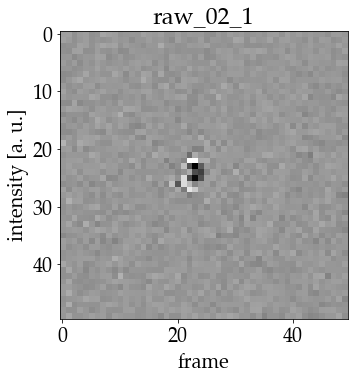

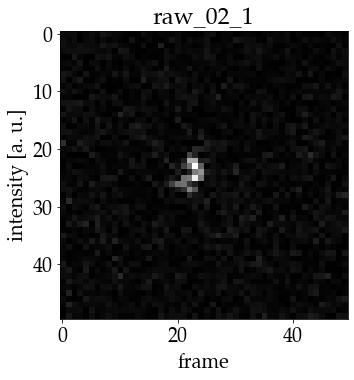

In [8]:
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title(file)
axes.set_xlabel('frame')
axes.set_ylabel('intensity [a. u.]')

axes.imshow(
    npp,
    cmap='gray'
)

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title(file)
axes.set_xlabel('frame')
axes.set_ylabel('intensity [a. u.]')

axes.imshow(
    np.abs(npp),
    cmap='gray'
)

In [10]:
# https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m


In [14]:
x = np.linspace(0, npp.shape[0] - 1, npp.shape[0])
y = np.linspace(0, npp.shape[1] - 1, npp.shape[1])
x, y = np.meshgrid(x, y)



In [123]:
def np_analysis(file_name):
    
    def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        x, y = xy
        xo = float(xo)
        yo = float(yo)    
        a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
        b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
        c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
        g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                                + c*((y-yo)**2)))
        return g.ravel()
    
    initial_guess = (0.03, 25, 25, 2, 2, 0, 10)

    npp = np.load(file_name + '.npy')
        
    x = np.linspace(0, npp.shape[0] - 1, npp.shape[0])
    y = np.linspace(0, npp.shape[1] - 1, npp.shape[1])
    x, y = np.meshgrid(x, y)
    
    try:
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), np.abs(npp).reshape(npp.shape[0] * npp.shape[1]), p0=initial_guess)
    except RuntimeError:
        return False
        
    data_fitted = twoD_Gaussian((x, y), *popt)
    lim = np.average(np.abs(npp)) * 4
    perr = np.sqrt(np.diag(pcov))
    
#     print('a: {}'.format(popt[0]))
#     print('xo, yo: {}'.format(popt[1:3]))
#     print('sx, sy: {}'.format(popt[3:5]))
#     print('offset: {}'.format(popt[6]))
    
#     print('lim: {}'.format(lim))
#     print('stdev err: {}'.format(perr))
    
    
    threshold = data_fitted.reshape(npp.shape) > popt[6] * 3
    
    area = np.sum(threshold * 1)
    intensity = np.sum(np.abs(npp)[threshold])
    intensity_px = np.average(np.abs(npp)[threshold])
    intensity_bg_px = np.average(np.abs(npp)[threshold == False])
    
    print('area: {}'.format(area))
    print('intensity: {}'.format(intensity))
    print('intensity/px: {}'.format(intensity_px))
    print('intensity bg/px: {}'.format(intensity_bg_px))
    snr = intensity_px/intensity_bg_px
    print('SNR: {}'.format(snr))
    print('-'*20)
    
    
    
#     fig, ax = plt.subplots(1, 1)
#     ax.imshow(npp, cmap='gray', origin='lower')
# #     ax.imshow(data_fitted.reshape(npp.shape), cmap='plasma', origin='lower', alpha = 0.5)
#     ax.imshow(threshold, cmap='plasma', origin='lower', alpha = 0.5)
    
    
    if any(perr > 1) or any(np.isnan(perr)) or np.abs(popt[3]) > 15 or np.abs(popt[4]) > 15 or popt[0] < 0 or popt[0] < lim:
        for s in ['left', 'right', 'bottom', 'top']:
                pass
#             ax.spines[s].set_color(COLORS[2])
#             ax.spines[s].set_linewidth(2)
        return False
    else:
        pass
#         plt.show()
#         fig.savefig(file_name +'_fit.png', dpi=300, bbox_inches='tight')
        
    return [area, intensity, intensity_px, intensity_bg_px, snr]

In [126]:
#save npy files as pngs
# folder = r'C:\SPRUP_data_Jenda\2019_03_13_Jenda_microscopy\20_12_11_BC5\exports_np_surroundings'.replace('\\', '/')
# file = 'raw_02_1'

folder = r'C:\SPRUP_data_Jenda\2019_03_13_Jenda_microscopy\21_04_14_DG600A1\exports_np_surroundings'.replace('\\', '/')
file = 'raw_06_3'

d = 0
t = 0
list_results = []

# for i in range(76,77):
# for i in range(70, 80):
# for i in range(166):
for i in range(1000, 2000):
    
# for i in range(146,147):
# for i in range(140, 150):
# for i in [66, 146]:
    t += 1
    name = file + '_{:04.0f}'.format(i)
    file_name = folder + '/' + name
    
    result = np_analysis(file_name)
    if type(result) is list:
        list_results.append(result)
        d += 1
results = np.matrix(list_results)
        
print('total: {}'.format(t))
print('analysed: {}'.format(d))
print('a/t: {}'.format(d/t))

area: 4
intensity: 0.015179635329590102
intensity/px: 0.0037949088323975255
intensity bg/px: 0.00042618936779092255
SNR: 8.90427851841487
--------------------
area: 5
intensity: 0.03048892582199675
intensity/px: 0.00609778516439935
intensity bg/px: 0.00048644910587850753
SNR: 12.535299357549428
--------------------
area: 4
intensity: 0.017562957244627322
intensity/px: 0.004390739311156831
intensity bg/px: 0.00047203787225510107
SNR: 9.301667449225272
--------------------
area: 2
intensity: 0.010973312372180688
intensity/px: 0.005486656186090344
intensity bg/px: 0.00058885959955459
SNR: 9.31742675204823
--------------------
area: 3
intensity: 0.010927729503526495
intensity/px: 0.0036425765011754985
intensity bg/px: 0.00047959540651340413
SNR: 7.595102979940014
--------------------
area: 5
intensity: 0.01837927968094777
intensity/px: 0.003675855936189554
intensity bg/px: 0.0004425397535848079
SNR: 8.306272840831047
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity b

<ipython-input-123-d03475ae32de>:29: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


area: 5
intensity: 0.017889205441436518
intensity/px: 0.0035778410882873037
intensity bg/px: 0.0005470296005288275
SNR: 6.540489006131502
--------------------
area: 2
intensity: 0.01701672244785729
intensity/px: 0.008508361223928645
intensity bg/px: 0.0005634012472602251
SNR: 15.101779176571085
--------------------
area: 4
intensity: 0.015206689717925936
intensity/px: 0.003801672429481484
intensity bg/px: 0.0005028688661889199
SNR: 7.559967787015981
--------------------
area: 5
intensity: 0.025724527507038686
intensity/px: 0.005144905501407737
intensity bg/px: 0.0004797820596349091
SNR: 10.723422016493824
--------------------
area: 7
intensity: 0.036713554000528975
intensity/px: 0.005244793428646997
intensity bg/px: 0.001027970710610557
SNR: 5.102084499598129
--------------------
area: 2
intensity: 0.016857776650976375
intensity/px: 0.008428888325488187
intensity bg/px: 0.000637354483956159
SNR: 13.224804308536058
--------------------
area: 2
intensity: 0.010589466311162712
intensity/p

area: 2
intensity: 0.009374483868682948
intensity/px: 0.004687241934341474
intensity bg/px: 0.0005254517289808478
SNR: 8.920404436450754
--------------------
area: 6
intensity: 0.03482181224412434
intensity/px: 0.005803635374020723
intensity bg/px: 0.0005861179094991347
SNR: 9.90182227835386
--------------------
area: 3
intensity: 0.024536945086734846
intensity/px: 0.008178981695578283
intensity bg/px: 0.0005141232104008402
SNR: 15.908602315778499
--------------------
area: 5
intensity: 0.023230431152547804
intensity/px: 0.004646086230509561
intensity bg/px: 0.0006071310960013795
SNR: 7.652525560145258
--------------------
area: 4
intensity: 0.022012123498658193
intensity/px: 0.005503030874664548
intensity bg/px: 0.0009906531977538636
SNR: 5.554951911669723
--------------------
area: 2
intensity: 0.016048744630178552
intensity/px: 0.008024372315089276
intensity bg/px: 0.0005287976035001156
SNR: 15.174751666754712
--------------------
area: 3
intensity: 0.013476640033021181
intensity/px

area: 4
intensity: 0.014265340452883163
intensity/px: 0.0035663351132207907
intensity bg/px: 0.00045629693858785975
SNR: 7.815820821103525
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0004641282359861129
SNR: nan
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0005894456338100203
SNR: nan
--------------------
area: 3
intensity: 0.024076000406553916
intensity/px: 0.008025333468851306
intensity bg/px: 0.000566599256469495
SNR: 14.164038122565696
--------------------
area: 10
intensity: 0.03775228821719001
intensity/px: 0.0037752288217190013
intensity bg/px: 0.0005661569620198611
SNR: 6.668166383135573
--------------------
area: 5
intensity: 0.022451083856578846
intensity/px: 0.004490216771315769
intensity bg/px: 0.0004987436002048573
SNR: 9.0030564191128
--------------------
area: 3
intensity: 0.038292402262681324
intensity/px: 0.012764134087560441
intensity bg/px: 0.0006638442463382267
SNR: 19.227603700668592
---------

--------------------
area: 5
intensity: 0.01763172126215927
intensity/px: 0.003526344252431854
intensity bg/px: 0.0004678479375829369
SNR: 7.537372657129065
--------------------
area: 5
intensity: 0.026769160328113356
intensity/px: 0.005353832065622672
intensity bg/px: 0.0005689997046088986
SNR: 9.40920007911537
--------------------
area: 5
intensity: 0.017238926519153847
intensity/px: 0.0034477853038307692
intensity bg/px: 0.0004726925298147044
SNR: 7.293928053363361
--------------------
area: 4
intensity: 0.016118873185267002
intensity/px: 0.0040297182963167505
intensity bg/px: 0.0004945793174985563
SNR: 8.147769536134138
--------------------
area: 3
intensity: 0.018266376945153734
intensity/px: 0.006088792315051245
intensity bg/px: 0.000436689589181196
SNR: 13.94306726310532
--------------------
area: 3
intensity: 0.011966343190893569
intensity/px: 0.00398878106363119
intensity bg/px: 0.0005172039083094725
SNR: 7.712202091954177
--------------------
area: 5
intensity: 0.023868045936

area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0011498808248809303
SNR: nan
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0005478310279207032
SNR: nan
--------------------
area: 2
intensity: 0.010256716685753453
intensity/px: 0.0051283583428767265
intensity bg/px: 0.0005841625670670035
SNR: 8.778991725925675
--------------------
area: 4
intensity: 0.02283885157476087
intensity/px: 0.005709712893690218
intensity bg/px: 0.0006102926216391821
SNR: 9.355697072585487
--------------------
area: 3
intensity: 0.012912932354301021
intensity/px: 0.004304310784767007
intensity bg/px: 0.0005054196630875596
SNR: 8.51631050219216
--------------------
area: 3
intensity: 0.021949914127175008
intensity/px: 0.0073166380423916695
intensity bg/px: 0.0006205692880142287
SNR: 11.790203259662295
--------------------
area: 4
intensity: 0.01562184953810547
intensity/px: 0.0039054623845263675
intensity bg/px: 0.0005735483515120717
SNR: 6.80929929312885
-----------

area: 5
intensity: 0.023615385776965675
intensity/px: 0.004723077155393135
intensity bg/px: 0.0005451377498562329
SNR: 8.664006770103033
--------------------
area: 4
intensity: 0.01728547328396332
intensity/px: 0.00432136832099083
intensity bg/px: 0.0004927094090037404
SNR: 8.770622687576937
--------------------
area: 4
intensity: 0.012952686821917372
intensity/px: 0.003238171705479343
intensity bg/px: 0.0005022795711789916
SNR: 6.446950844284673
--------------------
area: 3
intensity: 0.02111157278440906
intensity/px: 0.007037190928136354
intensity bg/px: 0.0005094798148073411
SNR: 13.812501935523107
--------------------
area: 2
intensity: 0.01354308365241988
intensity/px: 0.00677154182620994
intensity bg/px: 0.0012886129651339642
SNR: 5.2549074155139905
--------------------
area: 4
intensity: 0.019011469911835166
intensity/px: 0.0047528674779587915
intensity bg/px: 0.0006636250981903532
SNR: 7.161976680688297
--------------------
area: 4
intensity: 0.01861560819783309
intensity/px: 0

area: 4
intensity: 0.029387143771200497
intensity/px: 0.007346785942800124
intensity bg/px: 0.0005407506215812996
SNR: 13.58627368992412
--------------------
area: 5
intensity: 0.018964381467954025
intensity/px: 0.003792876293590805
intensity bg/px: 0.0005796442938702761
SNR: 6.543454897599056
--------------------
area: 3
intensity: 0.012955634438389596
intensity/px: 0.004318544812796532
intensity bg/px: 0.0007645633288312883
SNR: 5.648380781481975
--------------------
area: 5
intensity: 0.01870432020004245
intensity/px: 0.0037408640400084904
intensity bg/px: 0.0005768854074811541
SNR: 6.484587738736827
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0009130500969362029
SNR: nan
--------------------
area: 4
intensity: 0.014045540000370005
intensity/px: 0.003511385000092501
intensity bg/px: 0.0005929968451646791
SNR: 5.921422733905721
--------------------
area: 3
intensity: 0.0179570395078468
intensity/px: 0.005985679835948933
intensity bg/px: 0.00070131

area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0006225849054417504
SNR: nan
--------------------
area: 2
intensity: 0.01921511381038893
intensity/px: 0.009607556905194464
intensity bg/px: 0.0010856020407581648
SNR: 8.849980512642293
--------------------
area: 6
intensity: 0.02885195494627396
intensity/px: 0.0048086591577123266
intensity bg/px: 0.0005846459545473799
SNR: 8.224907946955838
--------------------
area: 6
intensity: 0.03260574868327687
intensity/px: 0.005434291447212812
intensity bg/px: 0.0005893510408638977
SNR: 9.220805717500692
--------------------
area: 7
intensity: 0.058475698785374175
intensity/px: 0.008353671255053454
intensity bg/px: 0.0010595150974346752
SNR: 7.8844287120396634
--------------------
area: 6
intensity: 0.030395363997447356
intensity/px: 0.0050658939995745595
intensity bg/px: 0.0005713664831302908
SNR: 8.866277860438245
--------------------
area: 5
intensity: 0.024592753398398476
intensity/px: 0.004918550679679695
intensity bg/px: 0.000609

area: 4
intensity: 0.014633662899260214
intensity/px: 0.0036584157248150534
intensity bg/px: 0.0004785219851835432
SNR: 7.6452406328035725
--------------------
area: 3
intensity: 0.01560742301650457
intensity/px: 0.005202474338834857
intensity bg/px: 0.0004984431269761499
SNR: 10.437448240877824
--------------------
area: 3
intensity: 0.012567463108342253
intensity/px: 0.004189154369447418
intensity bg/px: 0.0004906443070162809
SNR: 8.538067821315636
--------------------
area: 4
intensity: 0.028090453230732892
intensity/px: 0.007022613307683223
intensity bg/px: 0.0004813070128111043
SNR: 14.590714701344579
--------------------
area: 2
intensity: 0.007918174821862273
intensity/px: 0.003959087410931136
intensity bg/px: 0.0004724659230023404
SNR: 8.379625319372556
--------------------
area: 4
intensity: 0.014425354714766192
intensity/px: 0.003606338678691548
intensity bg/px: 0.0005335327141001893
SNR: 6.759358111289746
--------------------
area: 9
intensity: 0.06193796564561649
intensity/

area: 5
intensity: 0.03439458887739133
intensity/px: 0.006878917775478266
intensity bg/px: 0.000577721466072247
SNR: 11.90697971160037
--------------------
area: 4
intensity: 0.018175536419129723
intensity/px: 0.004543884104782431
intensity bg/px: 0.0005633056525248933
SNR: 8.066462824250872
--------------------
area: 3
intensity: 0.01658400350800454
intensity/px: 0.005528001169334847
intensity bg/px: 0.0007223778896835087
SNR: 7.6525060474328725
--------------------
area: 2
intensity: 0.015794952562637493
intensity/px: 0.007897476281318747
intensity bg/px: 0.0005716171363725263
SNR: 13.816024361053994
--------------------
area: 4
intensity: 0.021787117919379484
intensity/px: 0.005446779479844871
intensity bg/px: 0.0005951864466882776
SNR: 9.151383587700481
--------------------
area: 7
intensity: 0.027453175960178877
intensity/px: 0.003921882280025554
intensity bg/px: 0.0006630992542360157
SNR: 5.9144724639211335
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity b

area: 5
intensity: 0.025100734398485036
intensity/px: 0.005020146879697008
intensity bg/px: 0.00042923643206960616
SNR: 11.695528395602093
--------------------
area: 5
intensity: 0.029003950261679318
intensity/px: 0.005800790052335863
intensity bg/px: 0.0005213252559490784
SNR: 11.127007537310773
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0004719015081949416
SNR: nan
--------------------
area: 3
intensity: 0.015167491319433402
intensity/px: 0.0050558304398111336
intensity bg/px: 0.0005741048269410216
SNR: 8.80645868586387
--------------------
area: 4
intensity: 0.015570044031165353
intensity/px: 0.0038925110077913383
intensity bg/px: 0.0005520408836714519
SNR: 7.051128137292043
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0018015560788638921
SNR: nan
--------------------
area: 6
intensity: 0.027679723983218635
intensity/px: 0.004613287330536439
intensity bg/px: 0.0008229159688553691
SNR: 5.606024800993069
-------

area: 2
intensity: 0.011077811857160058
intensity/px: 0.005538905928580029
intensity bg/px: 0.000517872229819753
SNR: 10.695506747886176
--------------------
area: 7
intensity: 0.029774296829090607
intensity/px: 0.0042534709755843725
intensity bg/px: 0.0004918087828953112
SNR: 8.64862752255847
--------------------
area: 7
intensity: 0.032042042486030875
intensity/px: 0.004577434640861554
intensity bg/px: 0.0005433314560645587
SNR: 8.424755441212044
--------------------
area: 5
intensity: 0.03968389632712563
intensity/px: 0.007936779265425126
intensity bg/px: 0.0005173595885668569
SNR: 15.34093392839375
--------------------
area: 5
intensity: 0.02466116421887371
intensity/px: 0.004932232843774742
intensity bg/px: 0.0005360047965892114
SNR: 9.201844601317541
--------------------
area: 7
intensity: 0.02134223293332249
intensity/px: 0.0030488904190460703
intensity bg/px: 0.0006605587232268034
SNR: 4.615623580220635
--------------------
area: 5
intensity: 0.028245408628851748
intensity/px: 

area: 4
intensity: 0.021983799015752786
intensity/px: 0.005495949753938197
intensity bg/px: 0.0005521374828704206
SNR: 9.953951550918386
--------------------
area: 3
intensity: 0.013666078371097817
intensity/px: 0.0045553594570326055
intensity bg/px: 0.0005171019720505834
SNR: 8.809402599971124
--------------------
area: 5
intensity: 0.028259050177958517
intensity/px: 0.005651810035591703
intensity bg/px: 0.0005444742873754379
SNR: 10.380306594156105
--------------------
area: 3
intensity: 0.016328780865863785
intensity/px: 0.0054429269552879285
intensity bg/px: 0.0006717122877394437
SNR: 8.10306295513122
--------------------
area: 5
intensity: 0.02376258178200158
intensity/px: 0.0047525163564003155
intensity bg/px: 0.0005132858317688135
SNR: 9.259005533082535
--------------------
area: 2
intensity: 0.010465498113135047
intensity/px: 0.005232749056567523
intensity bg/px: 0.00077046132466166
SNR: 6.791708926941181
--------------------
area: 4
intensity: 0.01142335185253654
intensity/px:

area: 4
intensity: 0.017476910941753465
intensity/px: 0.004369227735438366
intensity bg/px: 0.0005342654471984536
SNR: 8.17800918691156
--------------------
area: 4
intensity: 0.03900283495188195
intensity/px: 0.009750708737970487
intensity bg/px: 0.0005565514486872011
SNR: 17.519869476524683
--------------------
area: 2
intensity: 0.016392479105735186
intensity/px: 0.008196239552867593
intensity bg/px: 0.0008182334483288447
SNR: 10.01699401265928
--------------------
area: 2
intensity: 0.013868757599140247
intensity/px: 0.006934378799570123
intensity bg/px: 0.0010992331412423785
SNR: 6.308378577207679
--------------------
area: 3
intensity: 0.016609805591485116
intensity/px: 0.005536601863828372
intensity bg/px: 0.0012852959183311994
SNR: 4.307647589060251
--------------------
area: 4
intensity: 0.03888867502915877
intensity/px: 0.009722168757289693
intensity bg/px: 0.0006182991235440597
SNR: 15.724053919990547
--------------------
area: 5
intensity: 0.03152830840400364
intensity/px: 

area: 4
intensity: 0.01915955330876598
intensity/px: 0.004789888327191495
intensity bg/px: 0.0007911386042432745
SNR: 6.054423714758594
--------------------
area: 5
intensity: 0.03295693608110978
intensity/px: 0.006591387216221956
intensity bg/px: 0.0005743678787953113
SNR: 11.475898042987433
--------------------
area: 4
intensity: 0.03033836113580468
intensity/px: 0.00758459028395117
intensity bg/px: 0.0007359932587039222
SNR: 10.305244231866428
--------------------
area: 5
intensity: 0.023815102064638535
intensity/px: 0.004763020412927707
intensity bg/px: 0.0005816023592034693
SNR: 8.189479182049533
--------------------
area: 6
intensity: 0.03338781223073012
intensity/px: 0.005564635371788353
intensity bg/px: 0.0006237381456115473
SNR: 8.921428665121125
--------------------
area: 6
intensity: 0.023885946142528203
intensity/px: 0.0039809910237547
intensity bg/px: 0.0005540816151150261
SNR: 7.184845905649216
--------------------
area: 2
intensity: 0.011556005324512009
intensity/px: 0.0

area: 3
intensity: 0.01650613536028106
intensity/px: 0.005502045120093686
intensity bg/px: 0.001173539629364381
SNR: 4.68841868005236
--------------------
area: 8
intensity: 0.03378825827974935
intensity/px: 0.004223532284968669
intensity bg/px: 0.0005207941491084494
SNR: 8.10979211690254
--------------------
area: 3
intensity: 0.01146356751929864
intensity/px: 0.0038211891730995464
intensity bg/px: 0.0005057214189179102
SNR: 7.5559172108544015
--------------------
area: 2
intensity: 0.009384165020806162
intensity/px: 0.004692082510403081
intensity bg/px: 0.0005291571091099467
SNR: 8.867087731836886
--------------------
area: 0
intensity: 0.0
intensity/px: nan
intensity bg/px: 0.0004484166599035242
SNR: nan
--------------------
area: 6
intensity: 0.03393749845836869
intensity/px: 0.005656249743061448
intensity bg/px: 0.0006507397260844446
SNR: 8.692030801770127
--------------------
area: 5
intensity: 0.0259691816957274
intensity/px: 0.00519383633914548
intensity bg/px: 0.00060435201744

area: 5
intensity: 0.0189555877352027
intensity/px: 0.00379111754704054
intensity bg/px: 0.0005590218996129751
SNR: 6.781697728953421
--------------------
area: 3
intensity: 0.016402953175402274
intensity/px: 0.005467651058467425
intensity bg/px: 0.00045449756148491525
SNR: 12.03009987689207
--------------------
area: 2
intensity: 0.01482753541447357
intensity/px: 0.007413767707236785
intensity bg/px: 0.0004752741614699621
SNR: 15.59892859377617
--------------------
area: 2
intensity: 0.018623461640072725
intensity/px: 0.009311730820036362
intensity bg/px: 0.0007881028072064533
SNR: 11.815375779516845
--------------------
area: 4
intensity: 0.014290758127845693
intensity/px: 0.0035726895319614232
intensity bg/px: 0.0005038117494122692
SNR: 7.091318406387326
--------------------
area: 5
intensity: 0.020029157072751352
intensity/px: 0.0040058314145502705
intensity bg/px: 0.0005116409749045265
SNR: 7.829379606075859
--------------------
area: 2
intensity: 0.01025370738347045
intensity/px:

In [127]:
print('area: {:.1f} +- {:.1f}'.format(np.average(results[:,0]), np.std(results[:,0])))
print('intensity: {:.5f} +- {:.5f}'.format(np.average(results[:,1]), np.std(results[:,1])))
print('intensity/px: {:.5f} +- {:.5f}'.format(np.average(results[:,2]), np.std(results[:,2])))
print('intensity_bg/px: {:.5f} +- {:.5f}'.format(np.average(results[:,3]), np.std(results[:,3])))
print('SNR: {:.1f} +- {:.1f}'.format(np.average(results[:,4]), np.std(results[:,4])))

area: 4.8 +- 2.0
intensity: 0.02409 +- 0.01038
intensity/px: 0.00518 +- 0.00161
intensity_bg/px: 0.00060 +- 0.00021
SNR: 9.0 +- 2.9


In [ ]:
area: 15.8 +- 6.6
intensity: 0.03714 +- 0.01542
intensity/px: 0.00252 +- 0.00099
intensity_bg/px: 0.00037 +- 0.00020
SNR: 7.4 +- 2.2

In [ ]:
area: 4.8 +- 2.0
intensity: 0.02409 +- 0.01038
intensity/px: 0.00518 +- 0.00161
intensity_bg/px: 0.00060 +- 0.00021
SNR: 9.0 +- 2.9

In [128]:
a = [i for i in range(100)]

In [135]:
500//500

1